<font size="6">Variational Inference - Time-Varying Performance of Market Eigenvectors</font>

<font size="5">Purpose</font>

One of the difficulties in dealing with financial time series data is that there are many time-varying parameters, and the distributions are not stationary. Clustering approaches may be used to discover where these parameters are varying, and give us some idea of the overall stability/instability of those time-varying parameters. 

If models are built with any assumptions about the parameters of the data, and those parameters shift, then the model assumptions are invalidated and that model will fail. Mixture models based on EM (expectation-maximization) partition the data into states where the covariance matrix and mean of the parameters within each state differ significantly. A nice feature of the Dirichlet process mixture model is that is it both a clustering and generative model from which we can generate new samples based on the fitted posterior distribution. 

<font size="5">Method</font>

Using variational inference applied to time series data, the algorithm non-parametrically chooses a likely number of clusters (latent states) each with distinct <b>mean and covariance</b> parameters allowing computation of a likelihood function for the 3-dimensional point at any time step. The model optimizes the parameters of the clusters to maximize the likelihood of those parameters given the data. 

In order to define what it means to be a good approximation the Kullback-Leibler divergence (KL divergence) is a non-symmetric measure of the difference between two probability distributions 𝑃 and 𝑄. This comes from information theory -- entropy is the average amount of information or "surprise" in the divergence between the distributions. 

$\huge D_{KL}(P \parallel Q) = \sum_{i} P(i) \log \frac{P(i)}{Q(i)}$

In the mean-field approximation, we also assume that the latent states will be partitioned so that each partition is independent. Using KL divergence, we can derive mutually dependent equations (one for each partition) that defines 𝑄 to approximate the posterior distribution. This is done for ease of computation for the iterative approach (expectation-maximization). Borrowing from Physics, in a system with many components that interact, those system interactions are replaced with a single average interaction (a "mean field"). 

The states' mean/covariances factorize, 

$\huge q(\boldsymbol{\theta}) \approx \prod_{i=1}^n q(\theta_i)$

$\huge q(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \approx \prod_{i=1}^n q(\mu_i) q(\Sigma_i)$

One <b>shortcoming</b> of this approach, which is shown in another notebook is that the model does not preserve auto-correlation between the samples, which is expected. Thus, a different approach will be needed to introduce auto-correlation structure into synthetic data (such as fractional gaussian noise which will be covered in another notebook). 

In [1]:
%pip install plotly
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 
import plotly.express as px
import scipy.stats as stats

from model.pca import eigenports

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 59.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


<font size=5>Principal Components</font>

As described in this paper: 
http://math.nyu.edu/faculty/avellane/AvellanedaLeeStatArb20090616.pdf

Before fitting the PCA will be Z-scoring the data for standardization. 

$\huge z\_score = \frac{x - \mu}{\sigma}$



In [6]:
m6 = pd.read_csv('./data/assets_m6.csv')

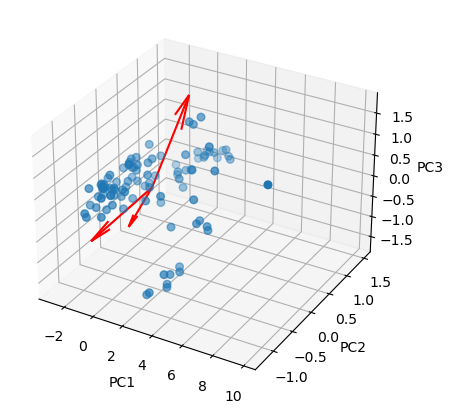

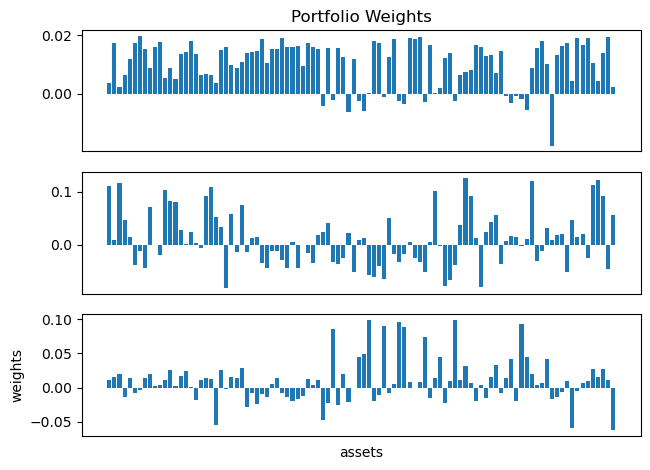

In [35]:
from sklearn.model_selection import train_test_split
m6_prices = pd.DataFrame()
m6_logreturn = pd.DataFrame()
m6_assets = pd.DataFrame()

assetlist = m6['symbol'].unique()
for sym in assetlist: 
    try:
        m6_prices[sym] = m6[m6['symbol'] == sym]['price'].reset_index().drop(columns=['index']).dropna()
        
        # Log Return (for calculating portfolio returns after PCA)
        m6_logreturn[sym] = m6_prices.copy()[sym].apply(np.log).diff().dropna()
        
        # Z-Score Returns (for fitting the PCA)
        m6_assets[sym] = stats.zscore(m6_prices.copy()[sym].pct_change().dropna())
    except:
        print(f'skip {sym}')
        
m6_assets = m6_assets.dropna()
m6_train, m6_test = train_test_split(m6_assets, train_size=0.5, test_size=0.5, shuffle=False)

eigenvectors, pca, components = eigenports(m6_train)
normed_vectors = [] 

# Plot the transformed data
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(components[:, 0], components[:, 1], components[:, 2], s=30)

# Plot the eigenvectors
origin = [0, 0, 0]
for eigenvector in eigenvectors:
    ax.quiver(0, 0, 0, eigenvector[0]*10, eigenvector[1]*10, eigenvector[2]*10, color='red')
    normed_vectors.append(eigenvector / sum(eigenvector))
     
# Label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

# Plot eigenvector weights
fig,ax=plt.subplots(3)
ax[0].bar(assetlist, normed_vectors[0], label='PC1')
ax[1].bar(assetlist, normed_vectors[1], label='PC2')
ax[2].bar(assetlist, normed_vectors[2], label='PC3')
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
plt.xlabel('assets')
plt.ylabel('weights')
ax[0].set_title('Portfolio Weights')
plt.tight_layout()
plt.show()

<font size="5">Fractional Differencing & Auto-Correlation Decay Plots</font>

Fractional differentiation of the performance of the eigenvector portfolios. Using a fractional order of 2 differences the data twice, leading to volatility clustering (2nd moment of the price). 

Note: you may need to restart the kernel to use updated packages.


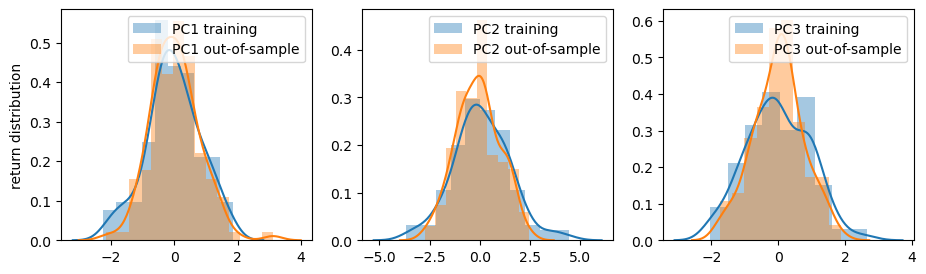

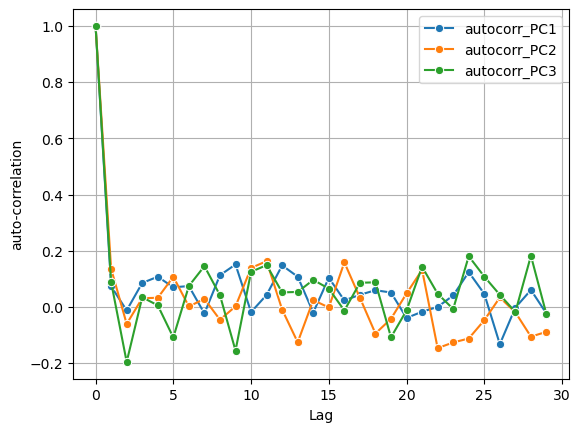

In [36]:
%pip install numpy-fracdiff
from model.regimes import relative_performances 
from numpy_fracdiff.fracdiff_fn import fracdiff

# Window length 
wlen = 10

# Get returns of top 3 eigenportfolios 
port1, port2, port3 = relative_performances(normed_vectors[0], normed_vectors[1], normed_vectors[2], m6_logreturn)
ports = pd.DataFrame() 
ports['PC1'] = np.cumsum(port1)
ports['PC2'] = np.cumsum(port2)
ports['PC3'] = np.cumsum(port3)

# Apply rolling mean 
#rolling_mean = lambda serie: [ np.mean(serie[x-wlen:x]) for x in range(wlen, len(serie)) ]
fn = lambda x: fracdiff(x.values, order=0.9)

mean_eigenportfolios = pd.DataFrame()
for p in ['PC1','PC2','PC3']: 
    mean_eigenportfolios[p] = fn(ports[p])
mean_eigenportfolios = mean_eigenportfolios.dropna().reset_index().drop(columns=['index'])

# View Performance in versus out of sample
insample1, insample2, insample3 = relative_performances(normed_vectors[0], normed_vectors[1], normed_vectors[2], m6_train)
oosample1, oosample2, oosample3 = relative_performances(normed_vectors[0], normed_vectors[1], normed_vectors[2], m6_test)
fig, ax = plt.subplots(1, 3, figsize=(11,3))
sns.distplot(insample1, label='PC1 training', ax=ax[0])
sns.distplot(oosample1, label='PC1 out-of-sample', ax=ax[0])
sns.distplot(insample2, label='PC2 training', ax=ax[1])
sns.distplot(oosample2, label='PC2 out-of-sample', ax=ax[1])
sns.distplot(insample3, label='PC3 training', ax=ax[2])
sns.distplot(oosample3, label='PC3 out-of-sample', ax=ax[2])
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_ylabel('return distribution')
ax[1].set_ylabel(None)
ax[2].set_ylabel(None)
plt.show()

# View Auto Correlation
decay_func = lambda S, _range: [S.apply(abs).autocorr(lag=Lag) for Lag in _range]
for p in ['PC1','PC2','PC3']: 
    sns.lineplot(data=decay_func(mean_eigenportfolios[p], range(0, 30)), label=f'autocorr_{p}', marker='o')
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.grid(True)
plt.show()

<font size=5> Non-Parametric Dirichlet Mixture Model </font>

Instantiate a non-parametric model using the dirichlet process and view the clustering results on the training data. The shaded regions on the plot represent the most frequently occurring state. 

In [37]:
num_components = 9
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, 
                                          weight_concentration_prior_type='dirichlet_process', 
                                          n_init=1, 
                                          max_iter=25)

In [38]:
dpgmm_model.fit(mean_eigenportfolios)
states = dpgmm_model.predict(mean_eigenportfolios)

state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

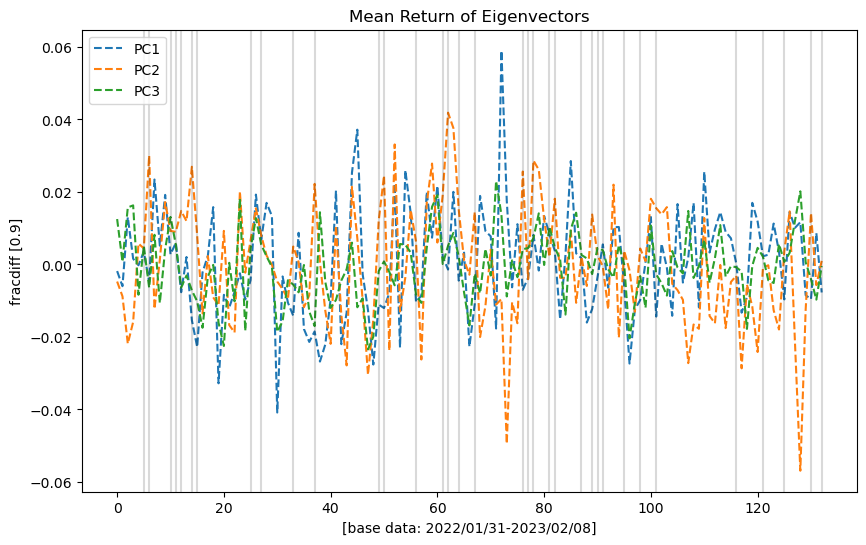

state_counts=
[ 0. 35.  1. 27. 21. 34.  6.  2.  7.]
means for shaded state=
[-0.00562949  0.01026127 -0.00030649]


In [39]:
fig,ax = plt.subplots(figsize=(10, 6
                     ))
for p in ['PC1','PC2','PC3']:
    sns.lineplot(x=mean_eigenportfolios.index, y=mean_eigenportfolios[p], ax=ax, label=f'{p}', linestyle='--')

for M in range(len(states)): 
  if states[M] == np.argmax(state_counts):
    ax.axvline(M, color='black', alpha=0.15)

ax.set_title('Mean Return of Eigenvectors')
ax.set_ylabel('fracdiff [0.9]')
ax.set_xlabel(f'[base data: 2022/01/31-2023/02/08]')
plt.show()

print('state_counts=')
print(state_counts)

print('means for shaded state=')
print(dpgmm_model.means_[np.argmax(state_counts)])

<font size=5> Precision Matrices to Graphs </font>

Note: you may need to restart the kernel to use updated packages.


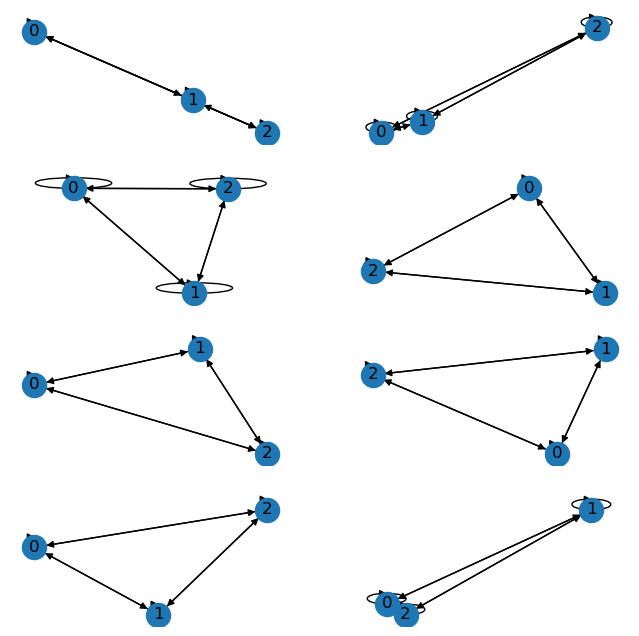

In [42]:
%pip install networkx 
import networkx as nx
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(4, 2, figsize=(8, 8))

i = 0
j = 0 
for pmat in dpgmm_model.precisions_:
    if state_counts[i] > 0: 
        ax = axes[j//2][j%2]
        G = nx.DiGraph(pmat)
        nx.draw(G, with_labels=True, ax=ax)
        j += 1
    i += 1

plt.show()